<h1> Chiết tách dữ liệu âm thanh và ứng dụng xây mô hình học máy nhận diện thể loại nhạc</h1>
<h4> Trong Colab notebook này, chúng ta sẽ thực hiện những công việc sau: </h4>
<ul>
  <li>Sử dụng thư viện Librosa để lấy mẫu file âm thanh</li>
  <li>Sử dụng Librosa kết hợp matplotlib để trực quan hóa file âm thanh</li>
  <li>Chọn lọc các đặc trưng của âm thanh, tổng hợp thành file .csv</li>
  <li>Xây dựng mô hình học máy dựa trên thư viện XGBoost (Gradient boosted trees) nhằm phân loại thể loại nhạc cho âm thanh
</ul>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import librosa
import IPython
import librosa.display as lplt
from google.colab import drive
import re
import os
seed = 12
np.random.seed(seed)

In [ ]:
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


<p> Bộ dữ liệu bài viết này sử dụng là GZTAN, được tạo ra bởi G. Tzanetakis và P. Cook vào năm 2002. 

GZTAN chứa 1000 bản nhạc, trải dài trên 10 thể loại nhạc khác nhau. Mỗi bản nhạc được lưu với định dạng .wav, mono, có độ dài khoảng 30 giây, được lấy mẫu ở tần số 22050 Hz. Đây là một trong các bộ dataset được sử dụng rộng rãi nhất (tính đến năm 2013, GZTAN được sử dụng trong hơn 100 công trình nghiên cứu khác nhau - theo B. Sturm).
</p>

<p> Trước hết ta sẽ load thử một file nhạc nhằm làm quen với việc trực quan hóa âm thanh </p>
<p> Chúng ta sử dụng hàm librosa.load().
Hàm này ở dạng đơn giản nhất nhận 1 đối số, là đường dẫn file. </p>
<p> Hàm trả về 2 giá trị, là list X - chuỗi thời gian đại diện cho âm thanh, và sr là tần số lấy mẫu.
Tần số lấy mẫu mặc định của Librosa là 22050 Hz. Tại lúc này, chúng ta có thể đặt ra câu hỏi, là vì sao Librosa chỉ lấy mẫu bằng 1/2 tần số thường gặp trên các file nhạc mp3, là 44100 Hz. </p>
<p> Thật vậy, theo định luật Nyqvist – Shannon, ta thường sẽ đặt tần số lấy mẫu thấp nhất là 2 lần tần số cao nhất của âm thanh. Cơ sở của số 44100 Hz chính là gấp đôi ngưỡng nghe của loài người. Vậy nhưng, việc giảm tần số mang lại các lợi ích về mặt bộ nhớ, đồng thời, tần số cao nhất mang thông tin thường có tần số dưới nốt C9 (tức 8372 Hz, thấp hơn tần số 11025 Hz). Nên ta về mặt lý thuyết có thể giảm tần số lấy mẫu đi một nửa mà không làm mất mát quá nhiều thông tin.</p>


In [ ]:
x, sr = librosa.load("/content/gdrive/MyDrive/Data/dataset_example/blues.00000.wav")
rock, sr = librosa.load('/content/gdrive/MyDrive/Data/dataset_example/rock.00000.wav')
classical, sr = librosa.load('/content/gdrive/MyDrive/Data/dataset_example/classical.00000.wav')
country, sr = librosa.load('/content/gdrive/MyDrive/Data/dataset_example/country.00000.wav')
hiphop, sr = librosa.load('/content/gdrive/MyDrive/Data/dataset_example/hiphop.00000.wav')
reggae, sr = librosa.load('/content/gdrive/MyDrive/Data/dataset_example/reggae.00000.wav')
IPython.display.Audio(x, rate=sr)

In [ ]:
print(x.shape[0])

661794


<p>Biểu đồ đầu tiên được gọi là waveform (âm phổ), thể hiện độ lớn (hay còn là biên độ, năng lương) của âm thanh trên một mốc thời gian cụ thể.</p>
<p>Nhìn thoạt tiên dạng biểu đồ này có vẻ không mang nhiều thông tin, thế nhưng trong các ngành như Ngôn ngữ học, ta có thể nhìn vào các biểu đồ dạng sóng này và dự doán được âm vị trong file âm thanh. Từ âm vị mà ta suy ra được nội dung được nói ra.</p>

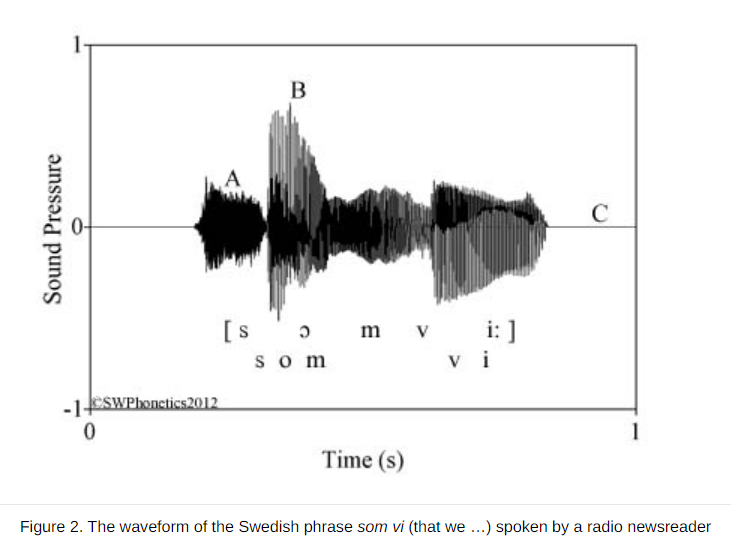

3. Periodicity: https://swphonetics.com/praat/tutorials/understanding-waveforms/

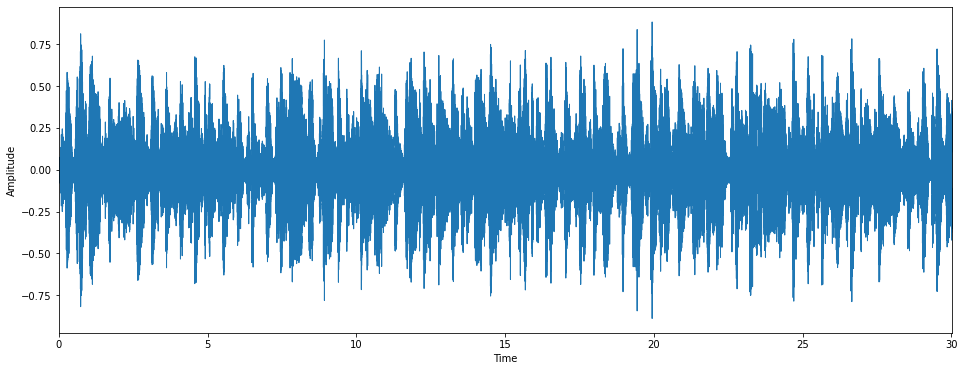

In [ ]:
plt.figure(figsize = (16, 6))
plt.xlabel('Time')
plt.ylabel('Amplitude')
lplt.waveplot(x)
plt.show()

<p> Âm phổ ứng với năng lượng của sóng âm trên một khoảng thời gian. </p>
Các thể loại nhạc khác nhau sẽ có dạng âm phổ khác nhau. Biểu đồ dưới đặt âm phổ của 6 bài hát với 6 thể loại khác nhau kề bên. Chúng ta có thê nhìn vào và đưa ra nhận xét.

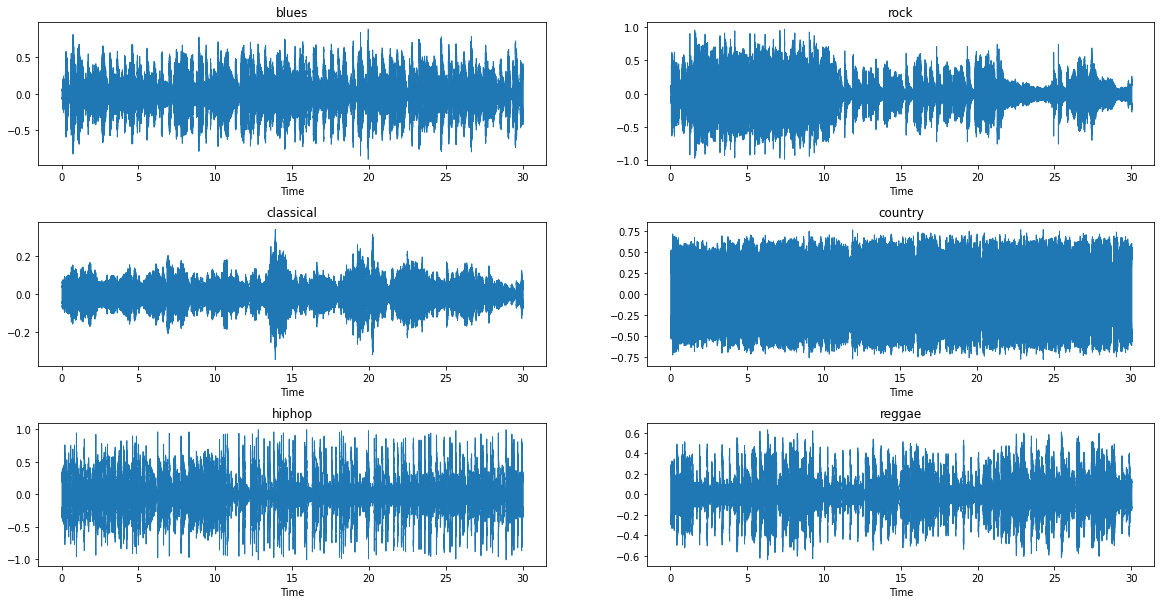

In [ ]:
fig, axs = plt.subplots(3, 2,figsize=(20,10))
lplt.waveshow(x, ax = axs[0,0])
axs[0,0].set(title='blues')
lplt.waveshow(rock, ax = axs[0,1])
axs[0,1].set(title='rock')
lplt.waveshow(classical, ax = axs[1,0])
axs[1,0].set(title='classical')
lplt.waveshow(country, ax = axs[1,1])
axs[1,1].set(title='country')
lplt.waveshow(hiphop, ax = axs[2,0])
axs[2,0].set(title='hiphop')
lplt.waveshow(reggae, ax = axs[2,1])
axs[2,1].set(title='reggae')
plt.subplots_adjust(hspace=0.4)
plt.show()

Có thể thấy rằng âm phổ của nhạc rock và nhạc hiphop rất lớn (chạm đến ngưỡng 1), trong đó nhạc classical và blues thì thấp hơn (chạm ngưỡng 0.5, 0.6)

<p>Trên waveform có nhiều thông tin hữu ích, trong đó có hòa âm (harmony) và nhịp điệu (percussion).</p>
<p> Hòa âm (trong âm nhạc) được định nghĩa là các nốt nhạc được xếp tầng lên nhau từ nhạc cụ gió hoặc dây, tạo ra độ dày cho âm nhạc </p>
<p> Nhịp điệu (trong âm nhạc) được định nghĩa là âm thanh lặp lại có tính chất chu kỳ tạo ra từ các nhạc cụ gõ, như trống và gõ, dùng để xác lập thời gian tương đối trong âm nhạc.</p>
<p> Ở biểu đồ dưới, ta chia waveform bên trên thành hòa âm (màu xanh) và nhịp điệu (màu đỏ)</p>

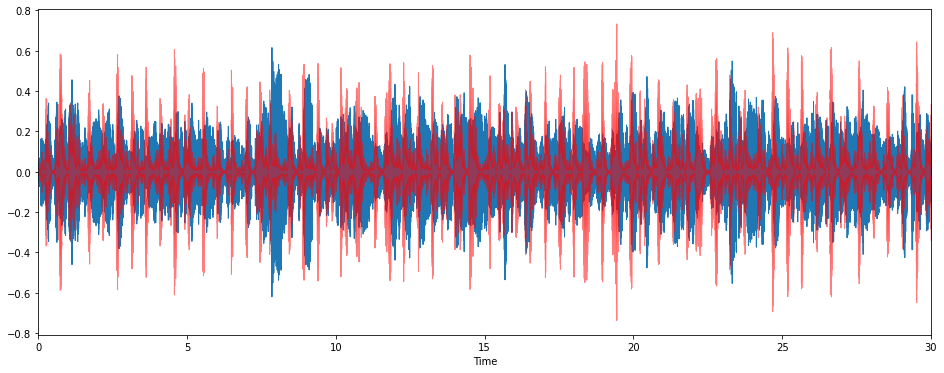

In [ ]:
y_harm, y_perc = librosa.effects.hpss(x)

plt.figure(figsize = (16, 6))
lplt.waveplot(y_harm)
lplt.waveplot(y_perc, color = 'red', alpha=0.5)
plt.show()

<p>Để xác định được tính trơn (smoothness) của âm thanh, ta có thể xét số lần tín hiệu đó điều hòa quanh một mốc nào đó, hay còn gọi là Zero crossing rate. Âm thanh tần số thấp sẽ điều hòa quanh mốc ít hơn âm thanh với tần số cao. Các bản nhạc có nhịp nhanh thường sẽ có giá trị zero crossing rate cao hơn</p>
<p> Ở đây, ta phóng to một đoạn waveform để nhìn rõ hơn khoảnh khắc âm thanh đi qua mốc 0 </p>

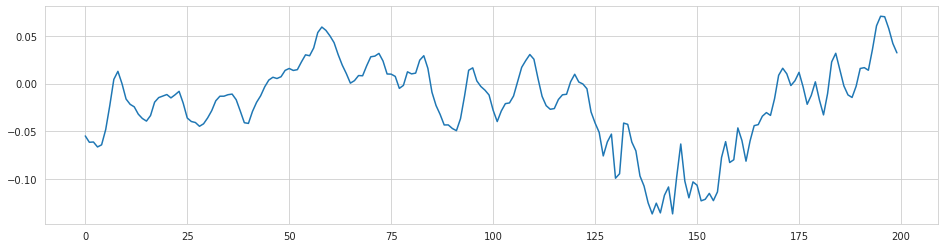

In [ ]:
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(x[start:end])
plt.show()

<p>Waveform còn cho chúng ta biết các đặc trưng khác của âm thanh, như Spectral Centroid, Spectral Bandwidth, Spectral Rolloff,... </p>

Biểu đồ bên dưới cho ta biểu diễn Spectral Centroid trên waveform. Spectral Centroid cho ta biết được trung bình có trọng số của các tần số trong âm thanh. Trọng số ở đây chính là cường độ của tần số đó.
Spectral Centroid có mối liên hệ vững chắc với timbre (tức độ sáng của âm thanh). Trị số SC này càng lớn, thì (thường) âm thanh đó cũng sẽ càng sáng

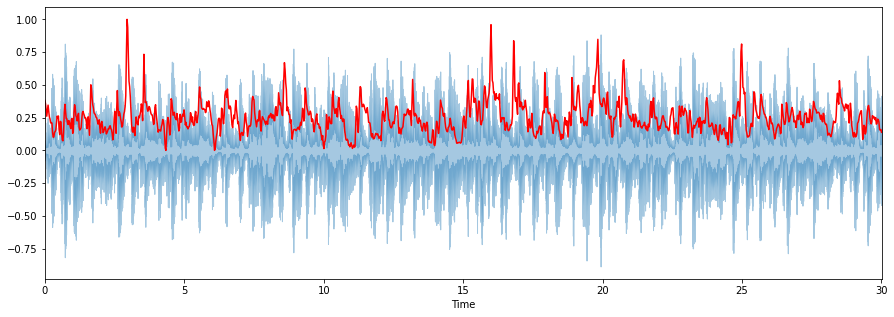

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

plt.figure(figsize=(15, 5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, skp.minmax_scale(spectral_centroids, axis=0), color='r')

<p>Biểu đồ dưới cho ta thấy được Spectral Bandwidth (còn gọi là Spectral Spread) trên waveform. Spectral Bandwidth là một phép đo hình dáng của phổ âm</p>
<p>Spectral Bandwidth đo sự phân bố của phổ xung quanh Centroid. Như vậy, các giá trị thấp của Spectral Bandwidth tương ứng với các tín hiệu có phổ tập trung dày đặc quanh Centroid</p>

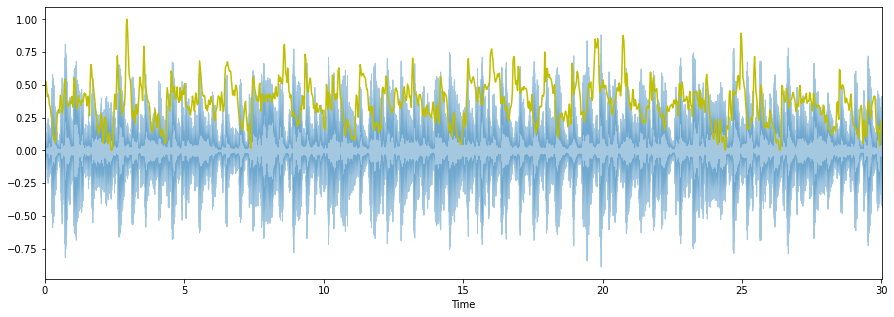

In [ ]:
spectral_band = librosa.feature.spectral_bandwidth(x, sr=sr)[0]

plt.figure(figsize=(15, 5))
frames = range(len(spectral_band))
t = librosa.frames_to_time(frames)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, skp.minmax_scale(spectral_band, axis=0), color='y')

<p> Biểu đồ dưới thể hiện giá trị Spectral Rolloff trên waveform. Spectral Rolloff được định nghĩa là tần số có cường độ dưới cường độ của phổ được tập trung (thường sẽ dưới 85% cường độ của phổ)

Giá trị này còn là một mô tả hình dạng phổ của tín hiệu âm thanh và có thể được sử dụng để phân biệt giữa âm thanh tiếng nói và âm thanh không phải tiếng nói. </p>

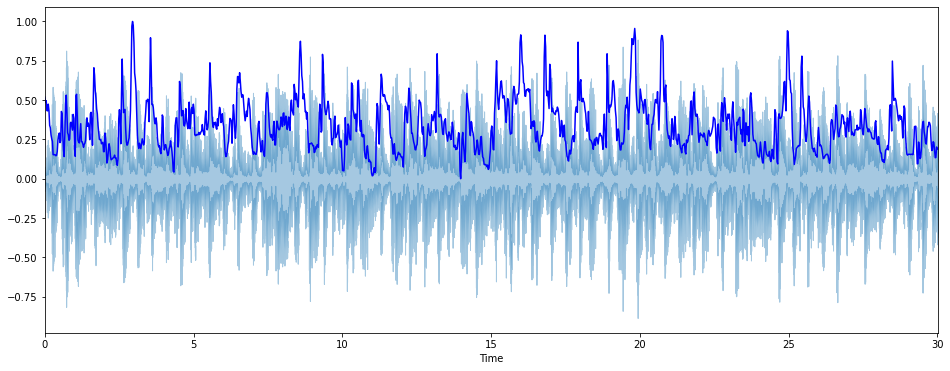

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
plt.figure(figsize = (16, 6))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4);
plt.plot(t, skp.minmax_scale(spectral_rolloff, axis=0), color='blue');

<p> Sau khi chạy librosa.load, âm thanh chuyển thành chuỗi thời gian đại diện cho âm thanh.</p>
<p> Root mean square là đặc trưng cho năng lượng của âm thanh </p>



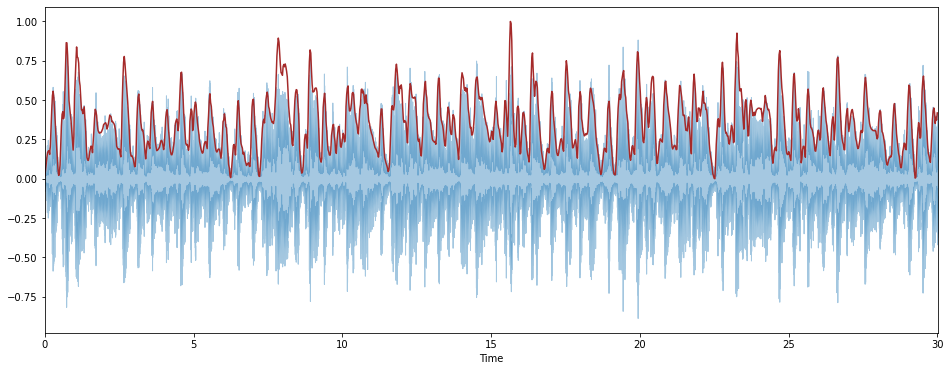

In [ ]:
plt.figure(figsize = (16, 6))
rms = librosa.feature.rms(x).ravel()
frames = range(len(rms.ravel()))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4);
plt.plot(t, skp.minmax_scale(rms, axis=0), color='brown');

Tempo, một đặc tính của âm nhạc, là số lượng nhịp trong một phút, thể hiện sự nhanh chậm của âm thanh.


In [ ]:
tempo, _ = librosa.beat.beat_track(x, sr = sr)
tempo

123.046875

<p> Một trong những đặc trưng của âm thanh chính là các sóng thành phần tại các tần số khác nhau hòa trộn, đan xen lẵn nhau. Để phân tích âm thanh thành các tổng của các sóng thành phần, ta sử dụng biến đổi Fourier. </p>
<p> Thế nhưng, phép biến đổi Fourier thường có cận thời gian là từ -∞ đến ∞. Điều này có nghĩa là ta chỉ có thể biết được thông tin về miền tần số, chứ không hề biết về thông tin về miền thời gian. Để khắc phục điều này, ta có thể bẻ tín hiệu thành các đoạn đủ nhỏ, từ đó cô lập được thông tin về các sóng về cả mặt tần số lẫn thời gian.
Đây cũng chính là ý tưởng của STFT: phân chia tín hiệu ra thành từng đoạn đủ nhỏ sao cho có thể xem tín hiệu trong mỗi đoạn là tín hiệu ổn định, sau đó, thực hiện biến đổi Fourier trên từng đoạn tín hiệu này.
Kết quả của phép stft là một dãy các số phức biểu diễn tần số và biên độ của các sóng thành phần. Ta tổng hợp các kết quả này và vẽ nên spectrogram bên dưới.

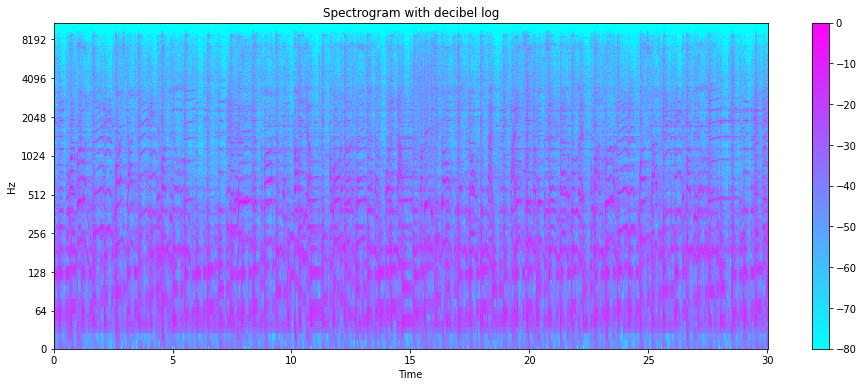

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

<p> Trong xử lý âm thanh, mel-frequency cepstrum (MFC) là một biểu diễn của phổ năng lượng ngắn hạn của âm thanh, dựa trên biến đổi cosine tuyến tính của logarit phổ năng lượng trên thang tần số mel phi tuyến. Mel-frequency cepstral coefficients (MFCC) là một cách biểu diễn thu gọn hơn của MFC.</p>
<p> </p>

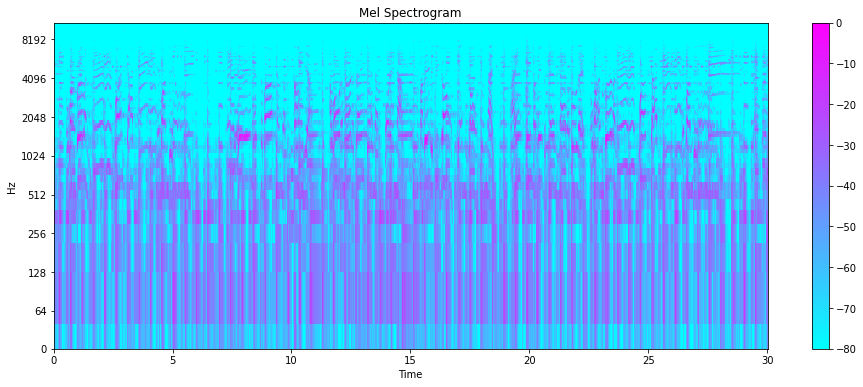

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

mel_spec = librosa.feature.melspectrogram(x, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

<p> Chroma là một dãy các đặc trưng vô cùng hữu hiệu với các file nhạc, vì toàn phổ âm sẽ được chia ra thành 12 phổ âm con, tương đương với 12 nốt trên thang nhạc Tây

Từng phổ âm con là một chuỗi thời gian biểu thị cường độ của nốt tương ứng đó.
</p>

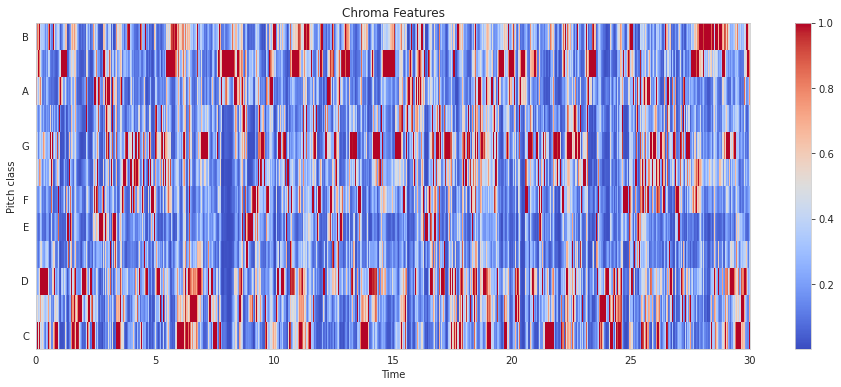

In [ ]:
chroma = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

<p> Giờ, ta sẽ sử dụng các thông tin trên để biến các file âm nhạc trở thành dataset.</p>

Như ta thấy ở trên, tất cả các thông tin âm thanh đều ở dạng chuỗi thời gian tương ứng với waveform và spectrogram đó (ngoại lệ ở đây là giá trị tempo). Chính vì vậy, ta cần tìm các giá trị đại diện cho các thông tin hơn.

Chính vì vậy, thay vì dùng trực tiếp các thông số ấy, ta sẽ sử dụng mean và variance của chúng.

Giá trị mean (trung bình, kỳ vọng), cho chúng ta biết được giá trị chung nhất trên chuỗi thời gian đó.

Giá trị variance (phương sai), cho ta biết mức độ phân tán của các giá trị của trên chuỗi thời gian so với giá trị trung tâm (kỳ vọng của chuỗi thời gian đó).

2 giá trị trên cho ta biết được đặc tính chung nhất của một chuỗi thời gian.

<p> Các đoạn code bên dưới sẽ giúp chúng ta tách các file nhạc có nhãn thành dataset và lưu thành file .csv

In [ ]:
def dataset_extraction(file):
  x, sr = librosa.load(file)
  filename = re.findall(".+/(.+wav$)", file)[0]
  length = x.shape[0]
  chroma = librosa.feature.chroma_stft(x, sr=sr)
  rms = librosa.feature.rms(x)
  spectral_centroid = librosa.feature.spectral_centroid(x, sr=sr)
  spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(x, sr=sr)
  zero_crossing_rate = librosa.feature.zero_crossing_rate(x)
  harmony, perceptr = librosa.effects.hpss(x)
  tempo = librosa.beat.tempo(x)
  mfccs = librosa.feature.mfcc(x, sr=sr)
  label = re.findall("(.+)\.\d+\.wav$", filename)[0]
  f1 = np.array([[np.mean(mfccs[i]), np.var(mfccs[i])] for i in range (0, 20)]).ravel()
  f1 = np.append(f1, label)
  f0 = np.array([filename, length, np.mean(chroma), np.var(chroma), np.mean(rms), np.var(rms), np.mean(spectral_centroid), np.var(spectral_centroid), np.mean(spectral_bandwidth), np.var(spectral_bandwidth), np.mean(rolloff), np.var(rolloff), np.mean(zero_crossing_rate), np.var(zero_crossing_rate), np.mean(harmony), np.var(harmony), np.mean(perceptr), np.var(perceptr), np.mean(tempo)])
  feature = np.append(f0, f1)
  return feature

In [ ]:
def get_wav(directory):
  ret = []
  for root, subFolder, files in os.walk(directory):
    for item in files:
      if item.endswith(".wav") :
        fileNamePath = str(os.path.join(root,item))
        ret.append(fileNamePath)
  return ret

In [ ]:
def generate_csv(directory, dest):
  name = ["filename", "length", "chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var",
          "spectral_centroid_mean", "spectral_centroid_var", "spectral_bandwidth_mean", 
          "spectral_bandwidth_var", "rolloff_mean", "rolloff_var", "zero_crossing_rate_mean", 
          "zero_crossing_rate_var", "harmony_mean", "harmony_var", "perceptr_mean",
          "perceptr_var", "tempo", "mfcc1_mean", "mfcc1_var", "mfcc2_mean", "mfcc2_var", 
          "mfcc3_mean", "mfcc3_var", "mfcc4_mean", "mfcc4_var", 'mfcc5_mean', "mfcc5_var", 
          "mfcc6_mean", "mfcc6_var", "mfcc7_mean", "mfcc7_var", "mfcc8_mean", "mfcc8_var", 
          "mfcc9_mean", "mfcc9_var", "mfcc10_mean", "mfcc10_var", "mfcc11_mean", "mfcc11_var", 
          "mfcc12_mean", "mfcc12_var", "mfcc13_mean", "mfcc13_var", "mfcc14_mean", 
          "mfcc14_var", "mfcc15_mean", "mfcc15_var", "mfcc16_mean", "mfcc16_var", 
          "mfcc17_mean", "mfcc17_var", "mfcc18_mean", "mfcc18_var", "mfcc19_mean", 
          "mfcc19_var", "mfcc20_mean", "mfcc20_var", "label"]
  
  data_dir = get_wav(directory)

  data = []
  for i in data_dir:
    try:
      data.append(dataset_extraction(i))
    except:
      print("Error when processing file " + str(i))

  dataset = pd.DataFrame(data, columns = name)
  dataset.to_csv(dest)

<p> Đoạn code dưới giúp chúng ta biến một file nhạc chưa có nhãn thành một dãy các đặc trưng để đưa vào mô hình học máy

In [ ]:
def extract_feature(file):
  name = ["length", "chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var",
          "spectral_centroid_mean", "spectral_centroid_var", "spectral_bandwidth_mean", 
          "spectral_bandwidth_var", "rolloff_mean", "rolloff_var", "zero_crossing_rate_mean", 
          "zero_crossing_rate_var", "harmony_mean", "harmony_var", "perceptr_mean",
          "perceptr_var", "tempo", "mfcc1_mean", "mfcc1_var", "mfcc2_mean", "mfcc2_var", 
          "mfcc3_mean", "mfcc3_var", "mfcc4_mean", "mfcc4_var", 'mfcc5_mean', "mfcc5_var", 
          "mfcc6_mean", "mfcc6_var", "mfcc7_mean", "mfcc7_var", "mfcc8_mean", "mfcc8_var", 
          "mfcc9_mean", "mfcc9_var", "mfcc10_mean", "mfcc10_var", "mfcc11_mean", "mfcc11_var", 
          "mfcc12_mean", "mfcc12_var", "mfcc13_mean", "mfcc13_var", "mfcc14_mean", 
          "mfcc14_var", "mfcc15_mean", "mfcc15_var", "mfcc16_mean", "mfcc16_var", 
          "mfcc17_mean", "mfcc17_var", "mfcc18_mean", "mfcc18_var", "mfcc19_mean", 
          "mfcc19_var", "mfcc20_mean", "mfcc20_var"]
  x, sr = librosa.load(file)
  length = x.shape[0]
  chroma = librosa.feature.chroma_stft(x, sr=sr)
  rms = librosa.feature.rms(x)
  spectral_centroid = librosa.feature.spectral_centroid(x, sr=sr)
  spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(x, sr=sr)
  zero_crossing_rate = librosa.feature.zero_crossing_rate(x)
  harmony, perceptr = librosa.effects.hpss(x)
  tempo = librosa.beat.tempo(x)
  mfccs = librosa.feature.mfcc(x, sr=sr)
  f1 = np.array([[np.mean(mfccs[i]), np.var(mfccs[i])] for i in range (0, 20)]).ravel()
  f0 = np.array([length, np.mean(chroma), np.var(chroma), np.mean(rms), np.var(rms), np.mean(spectral_centroid), np.var(spectral_centroid), np.mean(spectral_bandwidth), np.var(spectral_bandwidth), np.mean(rolloff), np.var(rolloff), np.mean(zero_crossing_rate), np.var(zero_crossing_rate), np.mean(harmony), np.var(harmony), np.mean(perceptr), np.var(perceptr), np.mean(tempo)])
  feature = np.append(f0, f1)
  ret = {name[i] : feature[i] for i in range(len(name))}
  return ret

<p> Ta sẽ generate mẫu thử một file .csv từ 10 file nhạc, vì trong thực tế, đoạn code này sẽ chạy rất lâu với bộ dữ liệu GTZAN </p>

Đoạn code sau sẽ tìm trong cây thư mục xem có file .csv không. Nếu có, sử dụng file .csv này làm dataset. Nếu không có, chạy hàm tạo dataset.

In [ ]:
fileNamePath = ""
for root, subFolder, files in os.walk('/content/gdrive/MyDrive/Data'):
  for item in files:
    if item.endswith(".csv"):
      fileNamePath = str(os.path.join(root,item))
      break
  break
if (len(fileNamePath) == 0):
  print("Generate file from scratch...")
  generate_csv('/content/gdrive/MyDrive/Data/dataset_example', '/content/features_30_sec.csv')
else:
  print("Found dataset!" + " " + fileNamePath)
  data = pd.read_csv(fileNamePath)
data.head()

Found dataset! /content/gdrive/MyDrive/Data/features_30_sec.csv


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
ret = ""
len(ret)

0

<p> Để đọc ghi dữ liệu, ta sử dụng thư viện Pandas

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Data/features_30_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


<p> Trước khi ta đưa dữ liệu vào mô hình học máy, ta cần tách dữ liệu thành tập data và tập nhãn riêng.

Đồng thời, ta cũng cần phải thực hiện normalize dữ liệu, do hiện dữ liệu đang ở các scale vô cùng khác nhau. </p>

In [ ]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

Sau đó, ta chia tập dữ liệu thành các bộ train và bộ validate.

In [ ]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.3, random_state=42)

<p> Cuối cùng, ta sẽ xây dựng mô hình thông qua thư viện Scikit-learn và xgboost. Mô hình được lựa chọn là XGBoost, với tham số n_estimators = 1000 và learning_rate = 0.05.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

Accuracy : 0.78333 



<p> Cuối cùng ta sẽ đưa một file wav vào và thử dự đoán dòng nhạc của bản nhạc đó.

In [ ]:
print(X_test.shape)

(300, 58)


In [ ]:
test = pd.DataFrame(pd.Series(extract_feature("/content/gdrive/MyDrive/Data/test_files/CantinaBand60.wav"))).T
print(xgb.predict(test)[0])

hiphop


REFERENCE:
https://musicinformationretrieval.com/index.html

https://wiki.aalto.fi/display/ITSP/Introduction+to+Speech+Processing

https://www.kaggle.com/code/nageshsingh/how-to-handle-audio-data/notebook

https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend

https://viblo.asia/p/audio-features-dac-trung-spectral-4P856z3B5Y3

https://viblo.asia/p/audio-features-dac-trung-cepstral-gDVK2emv5Lj

https://viblo.asia/p/tach-loi-khoi-nhac-cong-cu-khong-the-thieu-cho-cac-producer-phong-ngu-1Je5EXPLlnL

https://devopedia.org/audio-feature-extraction

https://stackoverflow.com/questions/53925401/difference-between-mel-spectrogram-and-an-mfcc#:~:text=The%20mel%2Dspectrogram%20is%20often,models%20like%20Gaussian%20Mixture%20Models.

https://numpy.org/

https://librosa.org/